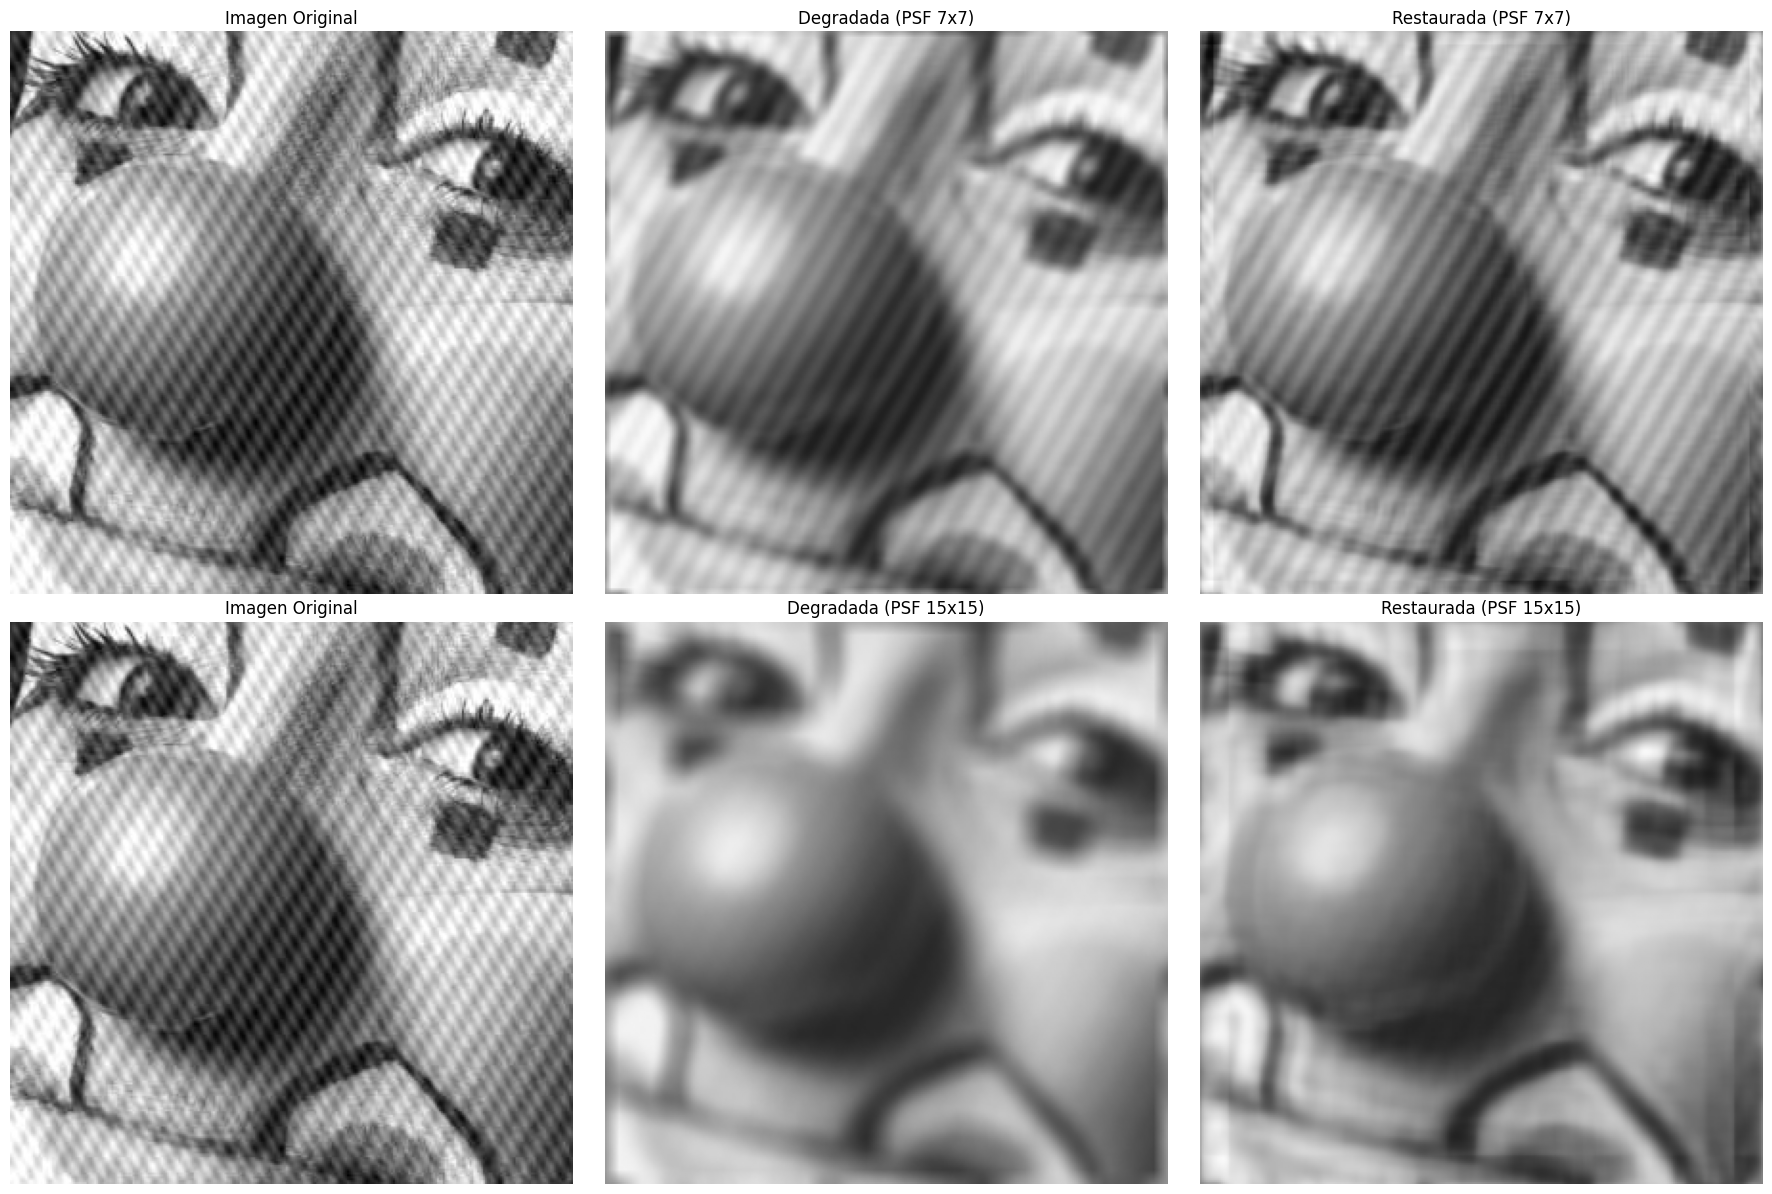

=== Mean Squared Error (MSE) ===

PSF 7x7:
  Imagen degradada:  0.004693
  Imagen restaurada: 0.003610
  Mejora: 23.08%

PSF 15x15:
  Imagen degradada:  0.010445
  Imagen restaurada: 0.007692
  Mejora: 26.36%


In [18]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import convolve2d

def mse(original, restored):
    return np.mean((original - restored) ** 2)
    
def normalize_psf(psf):
    psf = np.clip(psf, 1e-6, None)
    return psf / np.sum(psf)

def degrade_image(image, psf, noise_level=0.01):
    """Degrada la imagen con desenfoque y ruido"""
    blurred = convolve2d(image, psf, mode='same', boundary='wrap')
    noise = np.random.normal(0, noise_level * np.std(blurred), image.shape)
    return blurred + noise

def constrained_least_squares(degraded_image, psf, alpha=0.01, beta=0.01, iterations=50):
    """Restaura imagen degradada usando CLS iterativo"""
    estimate = np.copy(degraded_image)  # Mejor inicialización
    
    for _ in range(iterations):
        # Simular degradación de la estimación actual
        convolved = convolve2d(estimate, psf, mode='same', boundary='wrap')
        
        # Término de regularización
        regularization_term = alpha * estimate
        
        # Corrección multiplicativa (Richardson-Lucy style)
        ratio = degraded_image / (convolved + 1e-10)
        correction = convolve2d(ratio, psf[::-1, ::-1], mode='same', boundary='wrap')
        
        # Actualizar estimación
        estimate = estimate * correction / (1 + regularization_term + beta)
        estimate = np.clip(estimate, 0, 1)  # Mantener en rango válido
    
    return estimate

# Cargar y normalizar imagen
image = plt.imread('clown.jpg')
if image.ndim == 3:
    image = np.mean(image, axis=2)

# Normalizar a [0, 1]
image = image / 255.0 if image.max() > 1 else image

# Crear PSFs
psf_size = 7
psf = np.ones((psf_size, psf_size)) / (psf_size ** 2)
psf = normalize_psf(psf)

psf_size2 = 15
psf2 = np.ones((psf_size2, psf_size2)) / (psf_size2 ** 2)
psf2 = normalize_psf(psf2)

# PASO 1: Degradar la imagen original
degraded_image_1 = degrade_image(image, psf, noise_level=0.005)
degraded_image_2 = degrade_image(image, psf2, noise_level=0.005)

# PASO 2: Restaurar las imágenes degradadas
restored_image_1 = constrained_least_squares(degraded_image_1, psf, alpha=0.05, beta=0.01, iterations=100)
restored_image_2 = constrained_least_squares(degraded_image_2, psf2, alpha=0.05, beta=0.01, iterations=100)

# Visualización comparativa
fig, axes = plt.subplots(2, 3, figsize=(18, 12))

# Fila 1: PSF tamaño 7
axes[0, 0].imshow(image, cmap='gray', vmin=0, vmax=1)
axes[0, 0].set_title('Imagen Original')
axes[0, 0].axis('off')

axes[0, 1].imshow(degraded_image_1, cmap='gray', vmin=0, vmax=1)
axes[0, 1].set_title('Degradada (PSF 7x7)')
axes[0, 1].axis('off')

axes[0, 2].imshow(restored_image_1, cmap='gray', vmin=0, vmax=1)
axes[0, 2].set_title('Restaurada (PSF 7x7)')
axes[0, 2].axis('off')

# Fila 2: PSF tamaño 15
axes[1, 0].imshow(image, cmap='gray', vmin=0, vmax=1)
axes[1, 0].set_title('Imagen Original')
axes[1, 0].axis('off')

axes[1, 1].imshow(degraded_image_2, cmap='gray', vmin=0, vmax=1)
axes[1, 1].set_title('Degradada (PSF 15x15)')
axes[1, 1].axis('off')

axes[1, 2].imshow(restored_image_2, cmap='gray', vmin=0, vmax=1)
axes[1, 2].set_title('Restaurada (PSF 15x15)')
axes[1, 2].axis('off')

plt.tight_layout()
plt.show()

# Calcular MSE comparando restauraciones con imagen original
mse_degraded_1 = mse(image, degraded_image_1)
mse_restored_1 = mse(image, restored_image_1)
mse_degraded_2 = mse(image, degraded_image_2)
mse_restored_2 = mse(image, restored_image_2)

print("=== Mean Squared Error (MSE) ===")
print(f"\nPSF 7x7:")
print(f"  Imagen degradada:  {mse_degraded_1:.6f}")
print(f"  Imagen restaurada: {mse_restored_1:.6f}")
print(f"  Mejora: {((mse_degraded_1 - mse_restored_1) / mse_degraded_1 * 100):.2f}%")

print(f"\nPSF 15x15:")
print(f"  Imagen degradada:  {mse_degraded_2:.6f}")
print(f"  Imagen restaurada: {mse_restored_2:.6f}")
print(f"  Mejora: {((mse_degraded_2 - mse_restored_2) / mse_degraded_2 * 100):.2f}%")